In [1]:
import pandas as pd
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

seed = 7

data = pd.read_csv('data/sepsis_final.csv').drop(['Unnamed: 0', 'SUBJECT_ID', 'HADM_ID'], axis=1)
data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'M' else 0)

X = data.drop(['28 Day Death', 'In Hospital Death'], axis=1)
y = data['28 Day Death']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)

In [2]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

estimators = [('Scaler', StandardScaler()), ('Log_Reg', LogisticRegression(random_state=seed, solver='liblinear'))]
pipe = Pipeline(estimators)

clf = pipe.fit(X_train, y_train)


In [4]:
import importlib
import medical_explainer
importlib.reload(medical_explainer)

<module 'medical_explainer' from '/home/llja/repos/Uni_ACS/medical_explainer.py'>

| Step 1  ==> Calibrating model


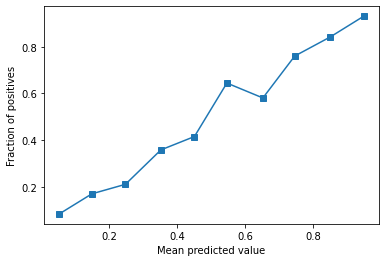

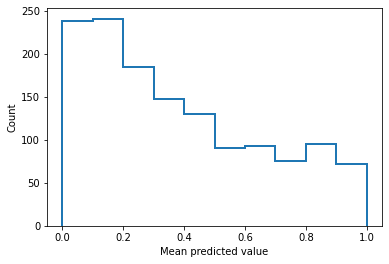

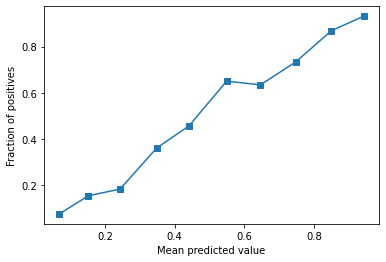

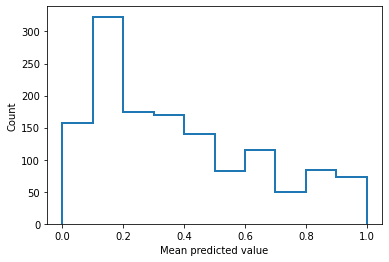

ROC AUC: 0.8157752847679719
Average Precision: 0.75387635987988
Accuracy: 0.7688368690563278
ROC AUC: 0.8177462325446518
Average Precision: 0.7562388064653908
Accuracy: 0.7666422823701536

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: 10.0

Probability threshold: 0.5
Score threshold: 22.0

Probability threshold: 0.9
Score threshold: 34.0



In [5]:
explainer = medical_explainer.explainer(
    clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='linear', method='novel')

In [6]:
scores,probs,predictions = explainer.predict_calculator(X_test, 1)

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

# accuracy = accuracy_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

# print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, predictions))


ROC AUC: 0.6935516025844335
Average Precision: 0.5626410573067779
Accuracy: 0.6664228237015362
[[700 144]
 [312 211]]


In [8]:
explainer.shap_array_list

[[0.46864409392402223, -0.9741497242978475],
 [-0.4402007552912632, 0.4123414112720419],
 [-0.4161137067199321, 0.3579317029029451],
 [-0.42187985371793457, 0.34031988689468007],
 [-0.2905886544484144, 0.30626291741859807],
 [0.26266987321883906, -0.2666915127982138],
 [0.2625786280637764, -0.25397883097292867],
 [-0.17282032095733527, 0.431915799953152],
 [-0.18345954388403815, 0.5095127534617112],
 [-0.18863322651698017, 0.29474243818508106]]

In [9]:
explainer.score_array_list

[array([ 2., -5.]),
 array([-2.,  2.]),
 array([-2.,  2.]),
 array([-2.,  2.]),
 array([-2.,  2.]),
 array([ 1., -1.]),
 array([ 1., -1.]),
 array([-1.,  2.]),
 array([-1.,  3.]),
 array([-1.,  2.])]

In [10]:
explainer.variables

array(['LOS', 'inotropes', 'Age', 'Bicarbonate', 'Chloride', 'Albumin',
       'Sodium', 'ICU_LOS', 'Bilirubin, Indirect', 'RDW'], dtype=object)

In [11]:
explainer.breakpoints_list

[[-0.3222222222222222, 15.512576648669132, 294.66041666666666],
 [0.0, 0.6575509937319136, 3.0],
 [18.258726899383984, 67.27633115541632, 90.0],
 [0.0, 22.718756067499626, 42.0],
 [74.0, 102.63850919523661, 140.0],
 [0.0, 2.9636059819929144, 18.290282614674197],
 [104.0, 138.3833302738173, 174.0],
 [0.008, 7.448128679355628, 153.928],
 [-35.02253587745486, 1.3292468399453985, 17.9],
 [11.6, 15.637431995364244, 30.5]]

In [12]:
scores,probs,predictions = explainer.predict_calculator(X_test, 1)

In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

# accuracy = accuracy_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

# print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, predictions))


ROC AUC: 0.6935516025844335
Average Precision: 0.5626410573067779
Accuracy: 0.6664228237015362
[[700 144]
 [312 211]]
